<a href="https://colab.research.google.com/github/gulshan0201/DATA-Science/blob/main/DS_Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

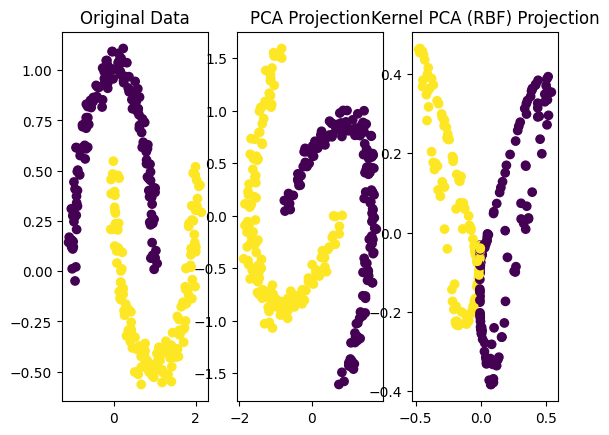

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

# Generate synthetic non-linear dataset (two moons)
X, y = make_moons(n_samples=300, noise=0.05, random_state=42)

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply Kernel PCA with RBF kernel
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X_scaled)

# Plot Original Data
plt.subplot(1, 3, 1)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis')
plt.title("Original Data")

# Plot PCA
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis')
plt.title("PCA Projection")

# Plot Kernel PCA
plt.subplot(1, 3, 3)
plt.scatter(X_kpca[:,0], X_kpca[:,1], c=y, cmap='viridis')
plt.title("Kernel PCA (RBF) Projection")

plt.show()


In [4]:
!pip install numpy scikit-learn matplotlib


=== PCA vs Kernel PCA — Metrics ===
         method  n_samples  n_components  recon_MSE (std space)  explained_variance_sum kernel    gamma
            PCA       4000             2               0.152466                0.772552   None      NaN
KernelPCA (RBF)       4000             2               0.270989                     NaN    rbf 0.188132


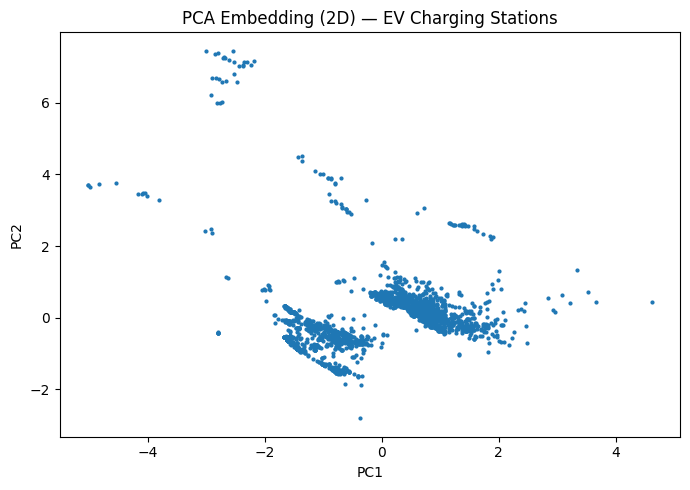

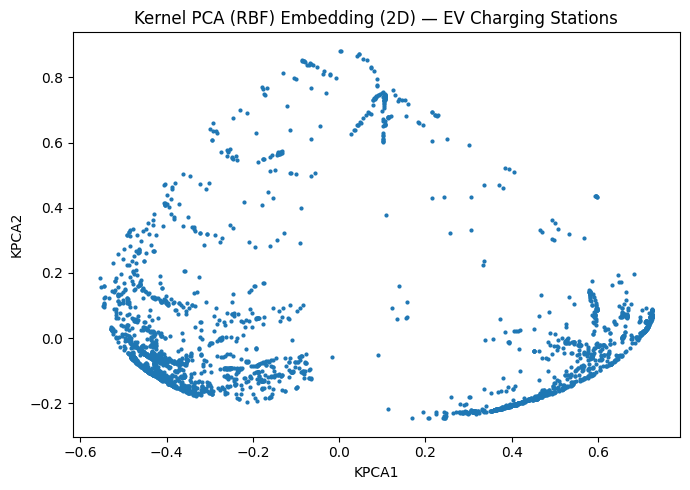

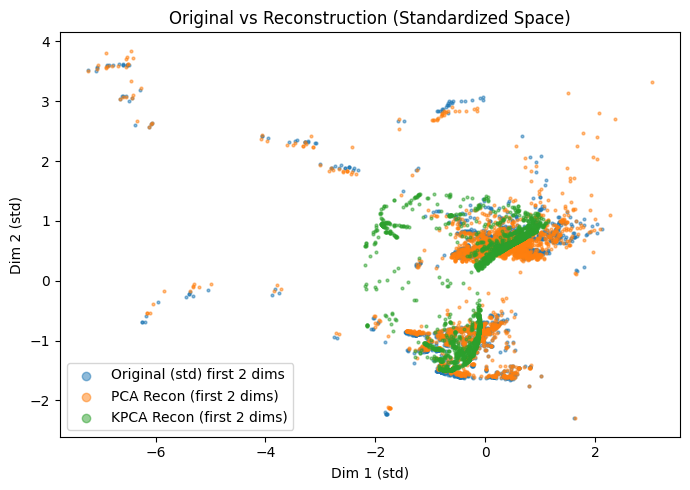

In [7]:
# PCA vs Kernel PCA on EV charging stations (2025 world dataset)
# --------------------------------------------------------------
# Requirements: pip install numpy pandas scikit-learn matplotlib
# File expected at: /mnt/data/charging_stations_2025_world.csv  (change PATH if needed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import pairwise_distances

# -----------------------
# Config (tunable)
# -----------------------
DATA_PATH = Path("charging_stations_2025_world.csv")  # <-- change if needed
FEATURES = ["latitude", "longitude", "ports", "power_kw"]
N_COMPONENTS = 2
RANDOM_STATE = 42

# Kernel PCA can be heavy (O(n^2)), so we sub-sample safely:
KPCA_SAMPLE_SIZE = 4000       # used for both PCA and KPCA to compare fairly
GAMMA_SUBSAMPLE = 500         # subset size to estimate RBF gamma via median distance
PLOT_SAMPLE = 3000            # points to show in each scatter for readability

# -----------------------
# 1) Load + Preprocess
# -----------------------
df = pd.read_csv(DATA_PATH)
X = df[FEATURES].copy()

# Drop missing; filter obvious non-sensical entries
X = X.dropna()
if "power_kw" in X: X = X[X["power_kw"] > 0]
if "ports"    in X: X = X[X["ports"] > 0]

# Standardize (very important for PCA/KPCA)
scaler = StandardScaler()
X_std = scaler.fit_transform(X.values)

n_total = X_std.shape[0]
rng = np.random.default_rng(RANDOM_STATE)

# Subset for manageable KPCA (and use same subset for PCA to compare apples-to-apples)
kpca_n = min(KPCA_SAMPLE_SIZE, n_total)
kpca_idx = rng.choice(n_total, size=kpca_n, replace=False)
X_kpca = X_std[kpca_idx]

# Separate subset for plotting
plot_n = min(PLOT_SAMPLE, kpca_n)
plot_idx_local = rng.choice(kpca_n, size=plot_n, replace=False)
X_plot = X_kpca[plot_idx_local]

# -----------------------
# 2) PCA (2 components)
# -----------------------
pca = PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
Z_pca = pca.fit_transform(X_kpca)
Xrec_pca = pca.inverse_transform(Z_pca)

# Reconstruction MSE in standardized space
pca_mse = float(np.mean((X_kpca - Xrec_pca) ** 2))
pca_explained = float(pca.explained_variance_ratio_.sum())

# -----------------------
# 3) Kernel PCA (RBF)
#    - gamma chosen via median pairwise distance heuristic
# -----------------------
gamma_subset_n = min(GAMMA_SUBSAMPLE, kpca_n)
gamma_idx = rng.choice(kpca_n, size=gamma_subset_n, replace=False)
X_gamma = X_kpca[gamma_idx]

# Median pairwise distance (avoid diagonal)
d = pairwise_distances(X_gamma, metric="euclidean")
median_dist = np.median(d[np.triu_indices_from(d, k=1)])
if median_dist <= 1e-12:  # degenerate edge case
    median_dist = 1.0

# RBF gamma ≈ 1 / (2 * sigma^2), with sigma ≈ median_dist
gamma = 1.0 / (2.0 * (median_dist ** 2))

kpca = KernelPCA(
    n_components=N_COMPONENTS,
    kernel="rbf",
    gamma=gamma,
    fit_inverse_transform=True,  # enables pre-image approximation for inverse_transform
    random_state=RANDOM_STATE
)
Z_kpca = kpca.fit_transform(X_kpca)
Xrec_kpca = kpca.inverse_transform(Z_kpca)
kpca_mse = float(np.mean((X_kpca - Xrec_kpca) ** 2))

# -----------------------
# 4) Comparison Table
# -----------------------
summary = pd.DataFrame([
    {
        "method": "PCA",
        "n_samples": kpca_n,
        "n_components": N_COMPONENTS,
        "recon_MSE (std space)": pca_mse,
        "explained_variance_sum": pca_explained,
        "kernel": None,
        "gamma": None,
    },
    {
        "method": "KernelPCA (RBF)",
        "n_samples": kpca_n,
        "n_components": N_COMPONENTS,
        "recon_MSE (std space)": kpca_mse,
        "explained_variance_sum": None,  # not directly comparable in KPCA
        "kernel": "rbf",
        "gamma": gamma,
    }
])
print("\n=== PCA vs Kernel PCA — Metrics ===")
print(summary.to_string(index=False))

# -----------------------
# Plots (plain matplotlib; one figure each; no custom colors)
# -----------------------

# PCA embedding
plt.figure(figsize=(7,5))
plt.scatter(Z_pca[plot_idx_local, 0], Z_pca[plot_idx_local, 1], s=4)
plt.title("PCA Embedding (2D) — EV Charging Stations")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()

# Kernel PCA embedding
plt.figure(figsize=(7,5))
plt.scatter(Z_kpca[plot_idx_local, 0], Z_kpca[plot_idx_local, 1], s=4)
plt.title("Kernel PCA (RBF) Embedding (2D) — EV Charging Stations")
plt.xlabel("KPCA1"); plt.ylabel("KPCA2")
plt.tight_layout(); plt.show()

# Reconstruction comparison (first two standardized dims)
plt.figure(figsize=(7,5))
plt.scatter(X_plot[:, 0], X_plot[:, 1], s=4, alpha=0.5, label="Original (std) first 2 dims")
plt.scatter(Xrec_pca[plot_idx_local, 0], Xrec_pca[plot_idx_local, 1], s=4, alpha=0.5, label="PCA Recon (first 2 dims)")
plt.scatter(Xrec_kpca[plot_idx_local, 0], Xrec_kpca[plot_idx_local, 1], s=4, alpha=0.5, label="KPCA Recon (first 2 dims)")
plt.title("Original vs Reconstruction (Standardized Space)")
plt.xlabel("Dim 1 (std)"); plt.ylabel("Dim 2 (std)")
plt.legend(markerscale=3)
plt.tight_layout(); plt.show()


